In [111]:
import cvxpy as cp
import numpy as np
from numpy import linalg as LA

# Make a cycle graph with n nodes
def one_way_cycle_graph(n):
    G = np.zeros((n, n))
    for i in range(n):
        G[i, (i+1)%n] = (np.random.rand()-0.5)*2
    return G

# Make a star graph with n nodes
def star_graph(n):
    G = np.zeros((n, n))
    for i in range(1, n):
        G[0, i] = (np.random.rand()-0.5)*2
        G[i, 0] = (np.random.rand()-0.5)*2
    return G

# Make a path graph with n nodes
def path_graph(n):
    G = np.zeros((n, n))
    for i in range(n-1):
        G[i, i+1] = (np.random.rand()-0.5)*2
        G[i+1, i] = (np.random.rand()-0.5)*2
    return G

# Make a random graph with n nodes
def random_graph(n):
    G = (np.random.rand(n, n)-0.5)*2
    np.fill_diagonal(G, 0)
    return G

# Make an upper triangular graph with n nodes
def upper_triangular_graph(n):
    G = np.triu((np.random.rand(n, n)-0.5)*2, k=1)
    return G

def utility(x, i, G, c):
    """Compute the utility of agent i given efforts x and adjacency matrix G"""
    return np.log(1 + x[i] + np.sum(G[i, :] * x)) - c[i] * x[i] ** 2

def best_response(x, i, G, c):
    """Compute the best response effort for agent i given efforts x and adjacency matrix G using CVXPY"""
    neighbors_sum = np.sum(G[i, :] * x)
    
    # Define the optimization variable
    xi = cp.Variable(nonneg=True)
    
    # Define the utility function for agent i
    utility_i = cp.log(1 + xi + neighbors_sum) - c[i] * xi ** 2
    
    # Define the optimization problem
    problem = cp.Problem(cp.Maximize(utility_i))
    
    # Solve the problem
    problem.solve()
    
    return xi.value

def find_optimal_efforts(G, c, tol=1e-6, max_iter=1000):
    """Iteratively find the optimal efforts for all agents"""
    n = len(c)
    x = np.zeros(n)  # Initial efforts
    iteration = 0
    while iteration < max_iter:
        x_old = np.copy(x)
        for i in range(n):
            x[i] = best_response(x, i, G, c)
        if np.linalg.norm(x - x_old) < tol:
            break
        iteration += 1
    return x

def social_welfare(x, G, c):
    """Compute the social welfare given efforts x and adjacency matrix G"""
    G_inf = np.sum([np.linalg.matrix_power(G, i) for i in range(100)], axis=0)
    sw = 0
    for i in range(n):
        sw += utility(x, i, G_inf, c)
    return sw

Adjacency matrix G:
[[ 0.         -0.31941089  0.          0.          0.        ]
 [ 0.          0.         -0.61795646  0.          0.        ]
 [ 0.          0.          0.         -0.4290857   0.        ]
 [ 0.          0.          0.          0.         -0.1447622 ]
 [ 0.95790714  0.          0.          0.          0.        ]]


In [122]:
# Define the adjacency matrix G
G = one_way_cycle_graph(5)

# Number of agents
n = G.shape[0]

# Cost coefficients roandom int with len n
c = np.random.rand(n)
print("Cost coefficients:", c)

# for multiple hops and G^hops:
hops = 10
optimal_efforts_list = []

G_k = np.zeros((n, n))
for i in range(hops):
    G_k += np.linalg.matrix_power(G, i+1)
    print(f"\nAdjacency matrix {i+1}-hops:")
    print(G_k)
    optimal_efforts = find_optimal_efforts(G_k, c)
    optimal_efforts_list.append(optimal_efforts)
    print("Optimal efforts:", optimal_efforts)


Cost coefficients: [0.81611192 0.75022507 0.12583066 0.69360298 0.44615365]

Adjacency matrix 1-hops:
[[0.         0.72561368 0.         0.         0.        ]
 [0.         0.         0.29446227 0.         0.        ]
 [0.         0.         0.         0.44382577 0.        ]
 [0.         0.         0.         0.         0.29158569]
 [0.10136111 0.         0.         0.         0.        ]]
Optimal efforts: [0.37331971 0.36906893 1.48323226 0.44125869 0.66005901]

Adjacency matrix 2-hops:
[[0.         0.72561368 0.21366585 0.         0.        ]
 [0.         0.         0.29446227 0.13068994 0.        ]
 [0.         0.         0.         0.44382577 0.12941324]
 [0.02955545 0.         0.         0.         0.29158569]
 [0.10136111 0.07354901 0.         0.         0.        ]]
Optimal efforts: [0.32318787 0.36094405 1.4537827  0.43960392 0.65409123]

Adjacency matrix 3-hops:
[[0.         0.72561368 0.21366585 0.09483041 0.        ]
 [0.         0.         0.29446227 0.13068994 0.03810732]


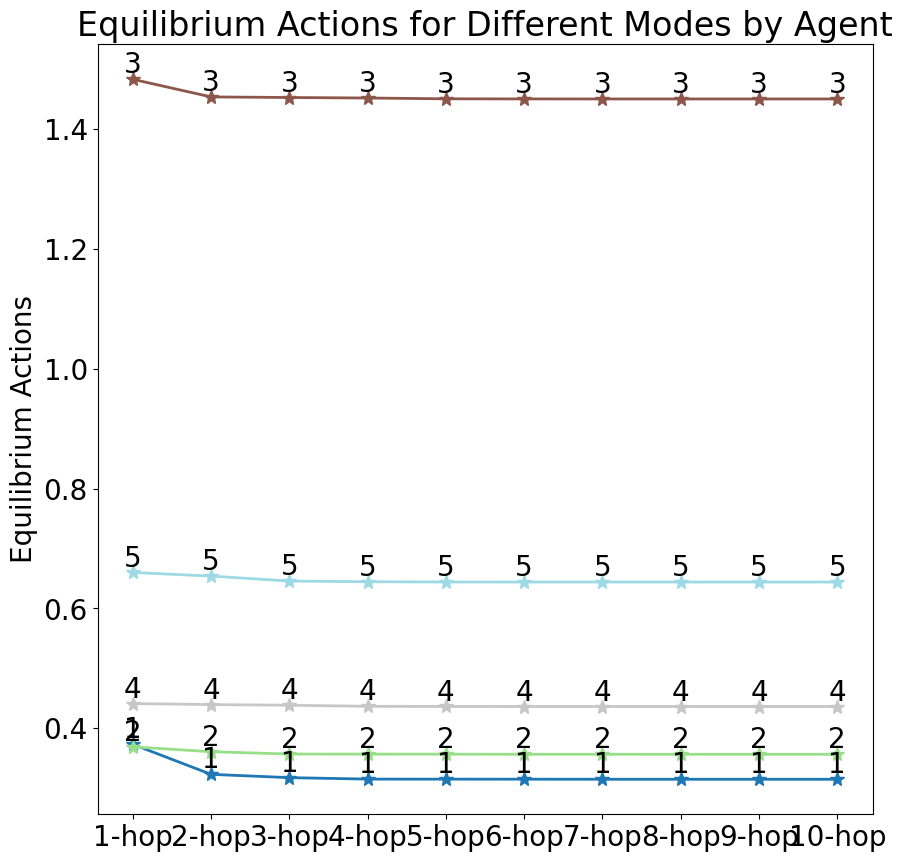

Social welfare for 1-hop: 3.9461906201976045
Social welfare for 2-hop: 3.909479818632765
Social welfare for 3-hop: 3.8995790049845924
Social welfare for 4-hop: 3.8966254722354075
Social welfare for 5-hop: 3.895709303934048
Social welfare for 6-hop: 3.895401576282569
Social welfare for 7-hop: 3.895314865138495
Social welfare for 8-hop: 3.895285566471895
Social welfare for 9-hop: 3.895269624549084
Social welfare for 10-hop: 3.895266512158776


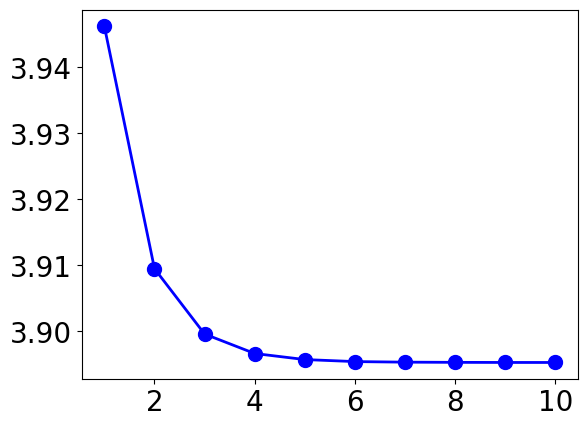

In [123]:
import matplotlib.pyplot as plt

equilibrium_values = np.array(optimal_efforts_list)

modes = ['{}-hop'.format(i+1) for i in range(hops)]
agents = ['Agent {}'.format(i+1) for i in range(n)]

# Define the x positions
x = np.arange(len(modes))

# Plotting the line chart
plt.figure(figsize=(10, 10))

plt.rcParams.update({'font.size': 20})

colors = plt.cm.tab20(np.linspace(0, 1, n))

# Adding lines for each agent
for i, (agent, color) in enumerate(zip(agents, colors)):
    plt.plot(x, equilibrium_values[:, i], marker='*', label=f'{agent}', color=color, linewidth=2, alpha=1, markersize=10)
    for j, value in enumerate(equilibrium_values[:, i]):
        plt.text(x[j], value, str(i+1), ha='center', va='bottom')

# Adding title and labels
plt.title('Equilibrium Actions for Different Modes by Agent')
plt.ylabel('Equilibrium Actions')
plt.xticks(x, modes)
# plt.legend()

plt.savefig('equilibrium_actions.png')
# Display the plot
plt.show()

# Compute the social welfare for each mode
social_welfare_values = [social_welfare(optimal_efforts, G, c) for optimal_efforts in optimal_efforts_list]

for i in range(hops):
    print(f"Social welfare for {i+1}-hop: {social_welfare_values[i]}")

plt.plot(range(1, hops+1), social_welfare_values, marker='o', color='b', linewidth=2, markersize=10)


Adjacency matrix 1-hops:
[[ 0.          0.15076168 -0.75773181  0.98206174 -0.81165411]
 [ 0.41720092  0.          0.          0.          0.        ]
 [-0.60207684  0.          0.          0.          0.        ]
 [ 0.20953746  0.          0.          0.          0.        ]
 [ 0.616154    0.          0.          0.          0.        ]]
Optimal efforts: [0.94558398 0.3763575  1.78960884 0.44005631 0.53039232]

Adjacency matrix 2-hops:
[[ 0.22478548  0.15076168 -0.75773181  0.98206174 -0.81165411]
 [ 0.41720092  0.06289791 -0.31612641  0.40971706 -0.33862284]
 [-0.60207684 -0.09077012  0.45621277 -0.59127662  0.48867814]
 [ 0.20953746  0.03159022 -0.1587732   0.20577872 -0.17007194]
 [ 0.616154    0.09289241 -0.46687948  0.60510127 -0.50010392]]


/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Optimal efforts: [0.76966429 0.49734789 1.47219145 0.50539395 0.7422211 ]

Adjacency matrix 3-hops:
[[ 0.22478548  0.18465072 -0.92805892  1.20281496 -0.99410217]
 [ 0.51098163  0.06289791 -0.31612641  0.40971706 -0.33862284]
 [-0.73741497 -0.09077012  0.45621277 -0.59127662  0.48867814]
 [ 0.25663844  0.03159022 -0.1587732   0.20577872 -0.17007194]
 [ 0.75465647  0.09289241 -0.46687948  0.60510127 -0.50010392]]
Optimal efforts: [0.90678739 0.46347141 1.54135269 0.48850086 0.68166895]

Adjacency matrix 4-hops:
[[ 0.275314    0.18465072 -0.92805892  1.20281496 -0.99410217]
 [ 0.51098163  0.07703645 -0.38718703  0.50181551 -0.41474034]
 [-0.73741497 -0.11117392  0.55876278 -0.72418703  0.59852589]
 [ 0.25663844  0.03869124 -0.19446311  0.25203479 -0.20830165]
 [ 0.75465647  0.11377328 -0.57182721  0.74111924 -0.61252003]]
Optimal efforts: [0.87103216 0.49326859 1.47994996 0.50340418 0.73488946]

Adjacency matrix 5-hops:
[[ 0.275314    0.19226848 -0.96634598  1.25243708 -1.03511385]
 [ 0.

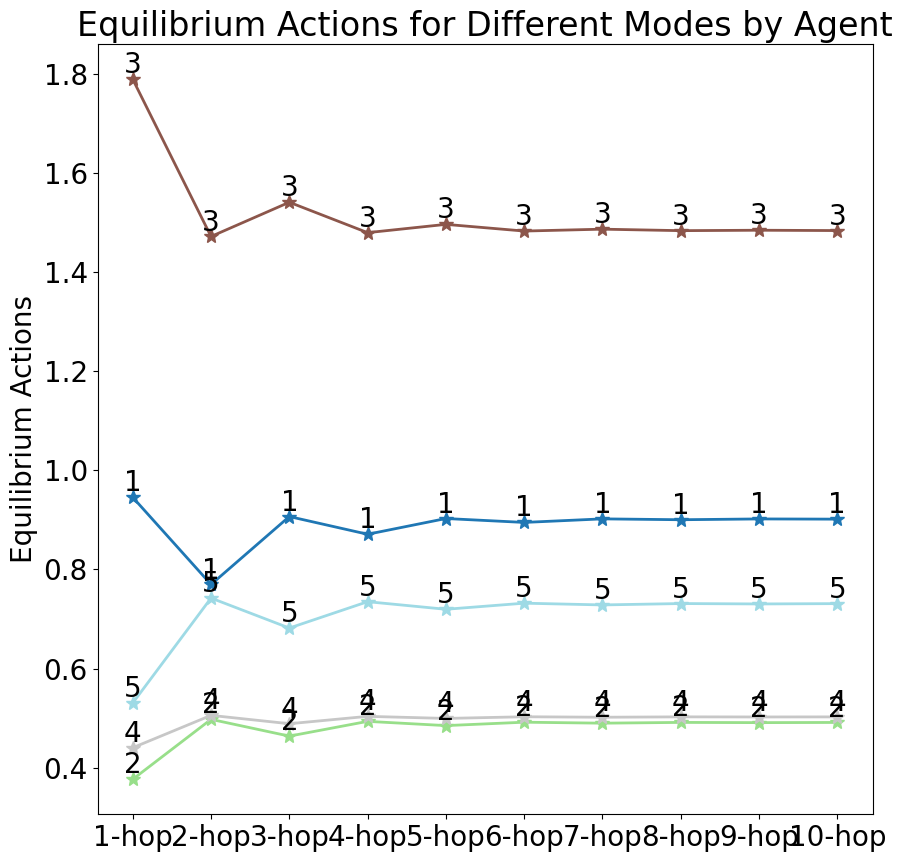

Social welfare for 1-hop: 2.0837889464630357
Social welfare for 2-hop: 2.339982381056956
Social welfare for 3-hop: 2.3905256511433053
Social welfare for 4-hop: 2.4256998214144896
Social welfare for 5-hop: 2.4313355800858742
Social welfare for 6-hop: 2.4383737205727196
Social welfare for 7-hop: 2.439355679486579
Social welfare for 8-hop: 2.4408854890000757
Social welfare for 9-hop: 2.4410946919560343
Social welfare for 10-hop: 2.4413708756618684


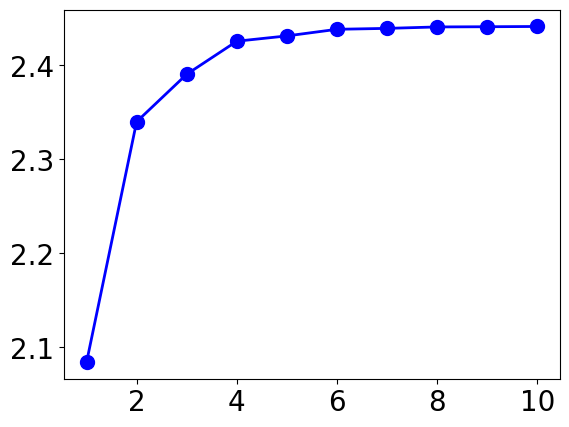

In [124]:
# for multiple hops and G^hops:
# hops = 5
optimal_efforts_list = []

G = star_graph(5)

G_k = np.zeros((n, n))
for i in range(hops):
    G_k += np.linalg.matrix_power(G, i+1)
    print(f"\nAdjacency matrix {i+1}-hops:")
    print(G_k)
    optimal_efforts = find_optimal_efforts(G_k, c)
    optimal_efforts_list.append(optimal_efforts)
    print("Optimal efforts:", optimal_efforts)

equilibrium_values = np.array(optimal_efforts_list)

modes = ['{}-hop'.format(i+1) for i in range(hops)]
agents = ['Agent {}'.format(i+1) for i in range(n)]

# Define the x positions
x = np.arange(len(modes))

# Plotting the line chart
plt.figure(figsize=(10, 10))

plt.rcParams.update({'font.size': 20})

colors = plt.cm.tab20(np.linspace(0, 1, n))

# Adding lines for each agent
for i, (agent, color) in enumerate(zip(agents, colors)):
    plt.plot(x, equilibrium_values[:, i], marker='*', label=f'{agent}', color=color, linewidth=2, alpha=1, markersize=10)
    for j, value in enumerate(equilibrium_values[:, i]):
        plt.text(x[j], value, str(i+1), ha='center', va='bottom')

# Adding title and labels
plt.title('Equilibrium Actions for Different Modes by Agent')
plt.ylabel('Equilibrium Actions')
plt.xticks(x, modes)
# plt.legend()

plt.savefig('equilibrium_actions.png')
# Display the plot
plt.show()

# Compute the social welfare for each mode
social_welfare_values = [social_welfare(optimal_efforts, G, c) for optimal_efforts in optimal_efforts_list]

for i in range(hops):
    print(f"Social welfare for {i+1}-hop: {social_welfare_values[i]}")

plt.plot(range(1, hops+1), social_welfare_values, marker='o', color='b', linewidth=2, markersize=10)


Adjacency matrix 1-hops:
[[ 0.         -0.20970538 -0.83772585  0.83232665 -0.40789556]
 [ 0.          0.         -0.35561547 -0.30488281  0.73616935]
 [ 0.          0.          0.          0.90510469  0.17542669]
 [ 0.          0.          0.          0.          0.81237568]
 [ 0.          0.          0.          0.          0.        ]]
Optimal efforts: [0.90655391 0.48643073 1.39371479 0.3753854  0.67077777]

Adjacency matrix 2-hops:
[[ 0.         -0.20970538 -0.76315137  0.13803262 -0.03307178]
 [ 0.          0.         -0.35561547 -0.62675204  0.42610552]
 [ 0.          0.          0.          0.90510469  0.91071173]
 [ 0.          0.          0.          0.          0.81237568]
 [ 0.          0.          0.          0.          0.        ]]
Optimal efforts: [0.80226981 0.56708757 1.24391323 0.3753854  0.67077777]

Adjacency matrix 3-hops:
[[ 0.         -0.20970538 -0.76315137  0.20553033 -0.58401701]
 [ 0.          0.         -0.35561547 -0.62675204  0.16462678]
 [ 0.          0

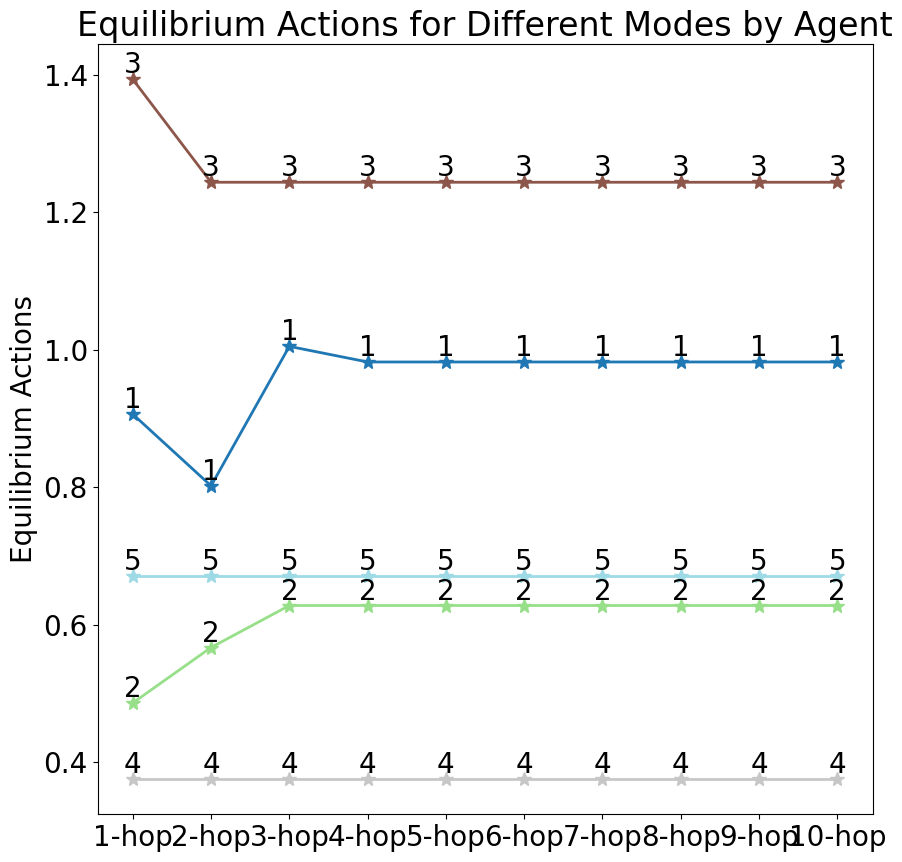

Social welfare for 1-hop: 2.4627993581549275
Social welfare for 2-hop: 2.5915133781608377
Social welfare for 3-hop: 2.5842844352322443
Social welfare for 4-hop: 2.5932268576904427
Social welfare for 5-hop: 2.5932268576904427
Social welfare for 6-hop: 2.5932268576904427
Social welfare for 7-hop: 2.5932268576904427
Social welfare for 8-hop: 2.5932268576904427
Social welfare for 9-hop: 2.5932268576904427
Social welfare for 10-hop: 2.5932268576904427


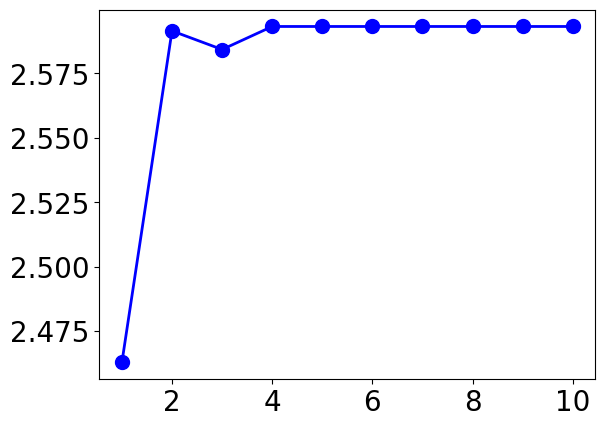

In [125]:
# for multiple hops and G^hops:
# hops = 5
optimal_efforts_list = []

G = upper_triangular_graph(5)

G_k = np.zeros((n, n))
for i in range(hops):
    G_k += np.linalg.matrix_power(G, i+1)
    print(f"\nAdjacency matrix {i+1}-hops:")
    print(G_k)
    optimal_efforts = find_optimal_efforts(G_k, c)
    optimal_efforts_list.append(optimal_efforts)
    print("Optimal efforts:", optimal_efforts)

equilibrium_values = np.array(optimal_efforts_list)

modes = ['{}-hop'.format(i+1) for i in range(hops)]
agents = ['Agent {}'.format(i+1) for i in range(n)]

# Define the x positions
x = np.arange(len(modes))

# Plotting the line chart
plt.figure(figsize=(10, 10))

plt.rcParams.update({'font.size': 20})

colors = plt.cm.tab20(np.linspace(0, 1, n))

# Adding lines for each agent
for i, (agent, color) in enumerate(zip(agents, colors)):
    plt.plot(x, equilibrium_values[:, i], marker='*', label=f'{agent}', color=color, linewidth=2, alpha=1, markersize=10)
    for j, value in enumerate(equilibrium_values[:, i]):
        plt.text(x[j], value, str(i+1), ha='center', va='bottom')

# Adding title and labels
plt.title('Equilibrium Actions for Different Modes by Agent')
plt.ylabel('Equilibrium Actions')
plt.xticks(x, modes)
# plt.legend()

plt.savefig('equilibrium_actions.png')
# Display the plot
plt.show()

# Compute the social welfare for each mode
social_welfare_values = [social_welfare(optimal_efforts, G, c) for optimal_efforts in optimal_efforts_list]

for i in range(hops):
    print(f"Social welfare for {i+1}-hop: {social_welfare_values[i]}")

plt.plot(range(1, hops+1), social_welfare_values, marker='o', color='b', linewidth=2, markersize=10)


Adjacency matrix 1-hops:
[[ 0.         -0.71744104  0.          0.          0.        ]
 [ 0.99560354  0.         -0.70853635  0.          0.        ]
 [ 0.         -0.30738934  0.         -0.33885517  0.        ]
 [ 0.          0.         -0.38502218  0.          0.90913385]
 [ 0.          0.          0.          0.29917164  0.        ]]
Optimal efforts: [0.56237557 0.65919461 1.70498647 0.50679063 0.62929408]

Adjacency matrix 2-hops:
[[-0.71428684 -0.71744104  0.50833306  0.          0.        ]
 [ 0.99560354 -0.49649031 -0.70853635  0.24009121  0.        ]
 [-0.30603792 -0.30738934  0.34826328 -0.33885517 -0.3080647 ]
 [ 0.          0.11835171 -0.38502218  0.40245382  0.90913385]
 [ 0.          0.         -0.11518772  0.29917164  0.27198707]]
Optimal efforts: [0.44881863 0.81802931 1.62041657 0.43380835 0.63848968]

Adjacency matrix 3-hops:
[[-0.71428684 -0.36123851  0.50833306 -0.17225128  0.        ]
 [ 0.50129603 -0.49649031 -0.44919536  0.24009121  0.21827504]
 [-0.30603792 -0

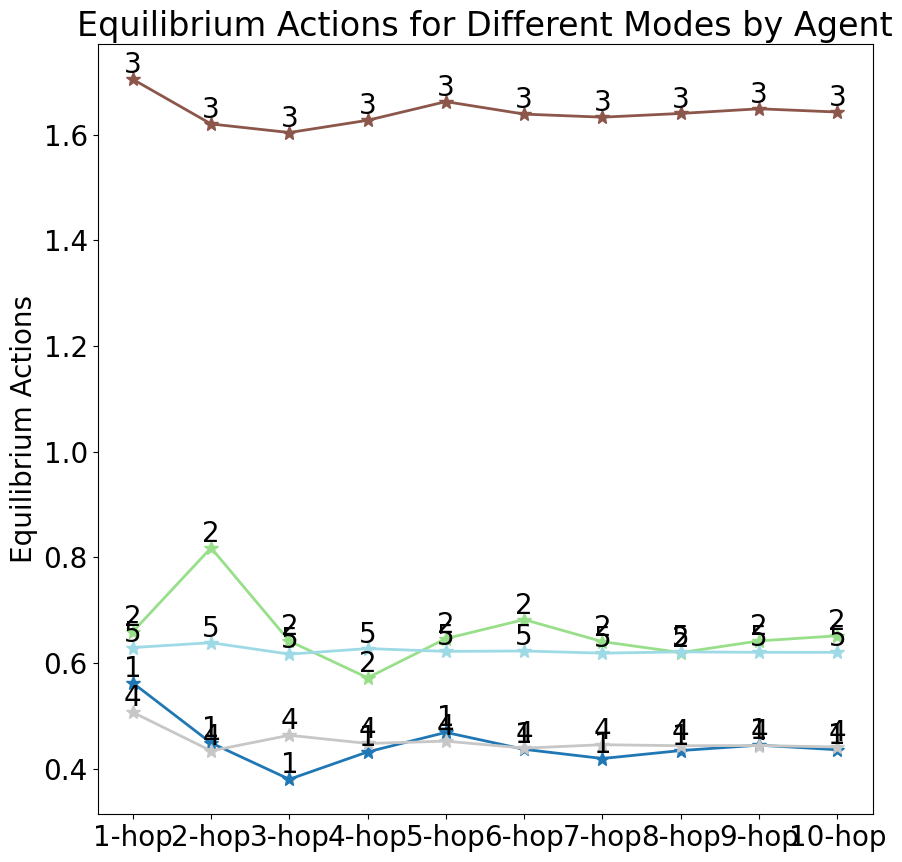

Social welfare for 1-hop: 3.1145142118185944
Social welfare for 2-hop: 2.9905356712873443
Social welfare for 3-hop: 3.0327496085190773
Social welfare for 4-hop: 3.0647168402923843
Social welfare for 5-hop: 3.057026174654932
Social welfare for 6-hop: 3.0312306290408078
Social welfare for 7-hop: 3.035463418939903
Social welfare for 8-hop: 3.045933813946667
Social welfare for 9-hop: 3.043263951170432
Social welfare for 10-hop: 3.0366494740804395


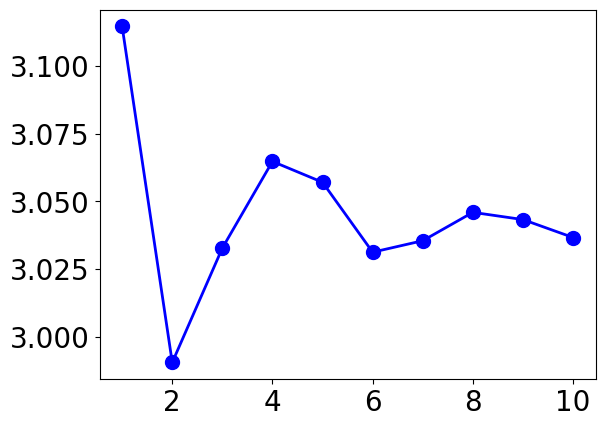

In [126]:
# for multiple hops and G^hops:
# hops = 5
optimal_efforts_list = []

G = path_graph(5)

G_k = np.zeros((n, n))
for i in range(hops):
    G_k += np.linalg.matrix_power(G, i+1)
    print(f"\nAdjacency matrix {i+1}-hops:")
    print(G_k)
    optimal_efforts = find_optimal_efforts(G_k, c)
    optimal_efforts_list.append(optimal_efforts)
    print("Optimal efforts:", optimal_efforts)

equilibrium_values = np.array(optimal_efforts_list)

modes = ['{}-hop'.format(i+1) for i in range(hops)]
agents = ['Agent {}'.format(i+1) for i in range(n)]

# Define the x positions
x = np.arange(len(modes))

# Plotting the line chart
plt.figure(figsize=(10, 10))

plt.rcParams.update({'font.size': 20})

colors = plt.cm.tab20(np.linspace(0, 1, n))

# Adding lines for each agent
for i, (agent, color) in enumerate(zip(agents, colors)):
    plt.plot(x, equilibrium_values[:, i], marker='*', label=f'{agent}', color=color, linewidth=2, alpha=1, markersize=10)
    for j, value in enumerate(equilibrium_values[:, i]):
        plt.text(x[j], value, str(i+1), ha='center', va='bottom')

# Adding title and labels
plt.title('Equilibrium Actions for Different Modes by Agent')
plt.ylabel('Equilibrium Actions')
plt.xticks(x, modes)
# plt.legend()

plt.savefig('equilibrium_actions.png')
# Display the plot
plt.show()

# Compute the social welfare for each mode
social_welfare_values = [social_welfare(optimal_efforts, G, c) for optimal_efforts in optimal_efforts_list]

for i in range(hops):
    print(f"Social welfare for {i+1}-hop: {social_welfare_values[i]}")

plt.plot(range(1, hops+1), social_welfare_values, marker='o', color='b', linewidth=2, markersize=10)

Adjacency matrix 1-hops:
[[ 0.00000000e+00  1.95798628e-01  5.63260235e-01  3.83448848e-01
   2.57947646e-01]
 [ 6.92076428e-01  0.00000000e+00  2.67460187e-01  4.49044314e-01
   5.50527136e-05]
 [-3.79733600e-01 -2.52435670e-01  0.00000000e+00  8.38970886e-01
   2.73595951e-01]
 [-2.58231815e-01 -1.60616660e-01  8.00730464e-01  0.00000000e+00
   7.53265832e-01]
 [-3.17951491e-01  6.82832244e-01  9.82407937e-01 -8.10207791e-01
   0.00000000e+00]]
Optimal efforts: [0.34064061 0.34928242 0.31810636 0.52664533 0.43970947]
Adjacency matrix 2-hops:
[[-0.25941475  0.16815835  1.17607756  0.73493886  0.70090306]
 [ 0.47453778 -0.00409528  1.01689686  0.93876693  0.5900003 ]
 [-0.85807759 -0.27471955  0.65916705  0.3583381   0.80759877]
 [-0.91295707  0.10104317  1.35233452 -0.10965499  0.90572331]
 [-0.00921126  0.50271584  0.33719089  0.19870767 -0.42349626]]
Optimal efforts: [0.28396182 0.27247286 0.30968256 0.51487534 0.40632146]
Adjacency matrix 3-hops:
[[-0.7428555   0.20867743  1.739178

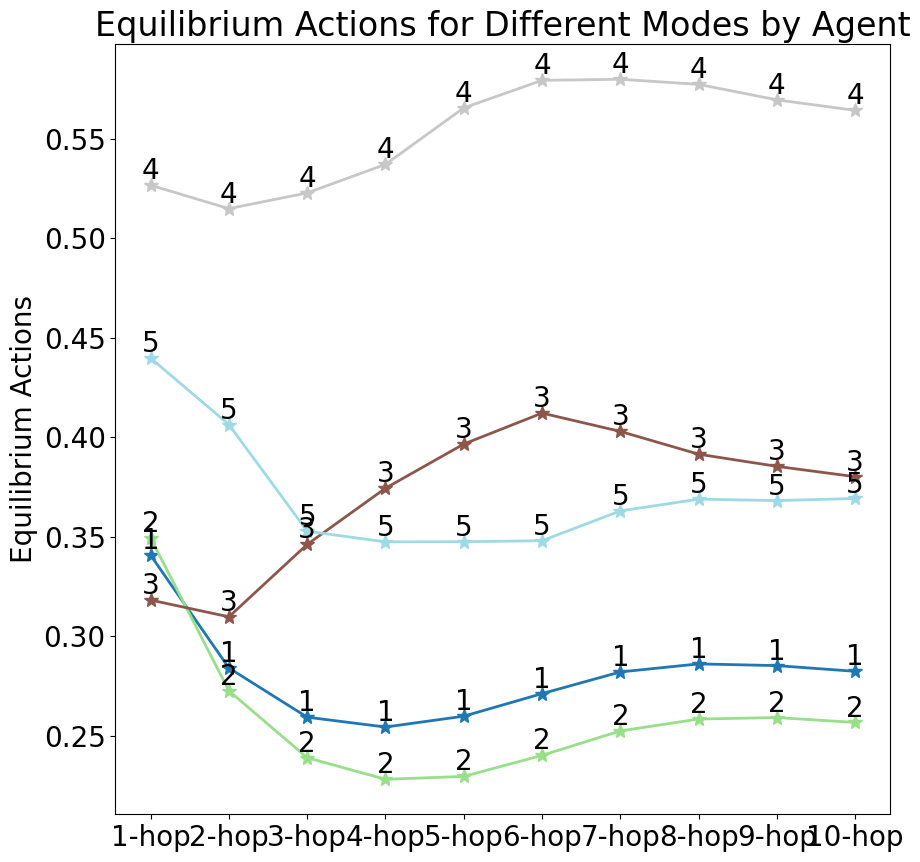

Social welfare for 1-hop: 3.568174250581043
Social welfare for 2-hop: 3.527589018295944
Social welfare for 3-hop: 3.558654442066717
Social welfare for 4-hop: 3.6354608156056774
Social welfare for 5-hop: 3.7103632863441263
Social welfare for 6-hop: 3.7523061665851243
Social welfare for 7-hop: 3.7486304553155723
Social welfare for 8-hop: 3.7269389546842864
Social welfare for 9-hop: 3.705806339019475
Social welfare for 10-hop: 3.6924469028202362


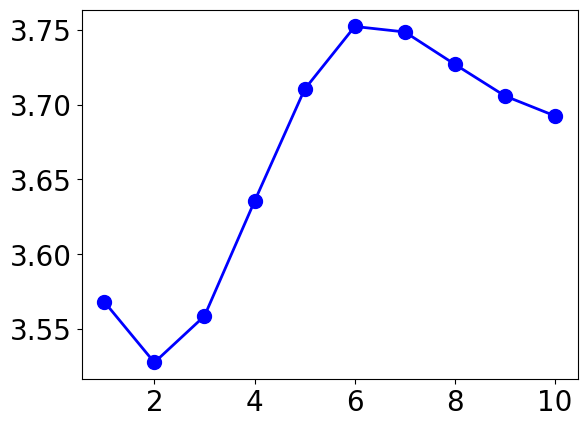

In [120]:
# for multiple hops and G^hops:
hops = 10
optimal_efforts_list = []

G = random_graph(5)

G_k = np.zeros((n, n))

for i in range(hops):
    G_k += np.linalg.matrix_power(G, i+1)
    print(f"Adjacency matrix {i+1}-hops:")
    print(G_k)
    optimal_efforts = find_optimal_efforts(G_k, c)
    optimal_efforts_list.append(optimal_efforts)
    print("Optimal efforts:", optimal_efforts)

equilibrium_values = np.array(optimal_efforts_list)

modes = ['{}-hop'.format(i+1) for i in range(hops)]
agents = ['Agent {}'.format(i+1) for i in range(n)]

# Define the x positions
x = np.arange(len(modes))

# Plotting the line chart
plt.figure(figsize=(10, 10))

plt.rcParams.update({'font.size': 20})

colors = plt.cm.tab20(np.linspace(0, 1, n))

# Adding lines for each agent
for i, (agent, color) in enumerate(zip(agents, colors)):
    plt.plot(x, equilibrium_values[:, i], marker='*', label=f'{agent}', color=color, linewidth=2, alpha=1, markersize=10)
    for j, value in enumerate(equilibrium_values[:, i]):
        plt.text(x[j], value, str(i+1), ha='center', va='bottom')

# Adding title and labels
plt.title('Equilibrium Actions for Different Modes by Agent')
plt.ylabel('Equilibrium Actions')
plt.xticks(x, modes)
# plt.legend()

plt.savefig('equilibrium_actions.png')
# Display the plot
plt.show()

# Compute the social welfare for each mode
social_welfare_values = [social_welfare(optimal_efforts, G, c) for optimal_efforts in optimal_efforts_list]

for i in range(hops):
    print(f"Social welfare for {i+1}-hop: {social_welfare_values[i]}")

plt.plot(range(1, hops+1), social_welfare_values, marker='o', color='b', linewidth=2, markersize=10)